# Barnes objective analysis examples
## Table of Contents
* ### [Load libraries](#libraries)
* ### [Define functions](#functions)
* ### [Example 1](#example1)
* ### [Example 2](#example2)

## <font color='darkblue'>Load libraries</font> <a class="anchor" id="libraries"></a>

In [1]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.interpolate import LinearNDInterpolator
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import cartopy
import warnings
from scipy.spatial.distance import cdist
import urllib
import xarray as xr
import urllib
import matplotlib.pyplot as plt
import cartopy
import numpy as np

## <font color='darkblue'>Define functions</font> <a class="anchor" id="functions"></a>

In [2]:
def calc_Verror(V, Vq, Xcell,ii, data): 
    interp = LinearNDInterpolator(list(zip(gridX, gridY)), Vq.flatten())
    interp_v = interp(data.lat,data.lon)
    Verr = V - interp_v 
    rmse = np.nanmean(Verr**2)
    outside =np.where(Verr.isna()==True)
    try:
        Verr[outside] = 0
    except:
        Verr[outside[0]] = 0
    print('Barnes iteration ' + str(ii) + ', average RMS error is ' + str(rmse))
    return rmse, Verr

def parse_inputs(X, V, Xv,n_interations=3, convergenceparam=0.2, gaussianvariance=float('nan')): 
    params={}
    params['iterations']=n_interations
    params['gaussianvariance']=gaussianvariance
    params['convergenceparameter']=convergenceparam #convergence parameter is to mitigate oversmoothing of data 
    
    if len(X) != len(V):
        raise Exception('The sizes of ''V'' and ''X'' do not match. V must have one value for each row in X')
    
    #remove data points with nan/inf
    remove = np.where(np.isfinite(X)==False)
    X[np.isfinite(X)]
    V[np.isfinite(V)]
    
    #setup parameters, store variable sizes
    params['D'] = X.ndim
    params['nData'] = len(X)
    params['grid_size'] = (len(Xv[0]),len(Xv[1]))
    params['nGrid'] = np.prod(params['grid_size'])
    
    
    A = np.prod(np.max(X, axis=0) - np.min(X,axis=0))
    M = params['nData']
    params['data_spacing'] = sqrt(A)*(1+sqrt(M))/(M-1) #put into dict params
    
    params['optimal_var']=(2*params['data_spacing']/math.pi)**2 * params['convergenceparameter']**(-params['iterations'])
    
    if math.isnan(params['gaussianvariance'])== True:
        params['gaussianvariance'] = params['optimal_var']
    else: 
        raise Exception('Gaussian variance is small. The optimal value is '+str(optimal_var))
    
    params['gaussianstd'] = sqrt(params['gaussianvariance'])


    # Warn if the grid spacing is not appropriate for the data spacing
    #Limits from Koch 1983: 1/3 <= (dn/[grid spacing]) <= 1/2, where dn is the average nearest-neighbor spacing of the data points
    min_grid_spacing = min((np.diff(Xv[0]).min(),np.diff(Xv[1]).min()))
    max_grid_spacing = max((np.diff(Xv[0]).max(),np.diff(Xv[1]).max()))
    if (min_grid_spacing/params['data_spacing']) < 0.333:
        warnings.warn('Grid spacing should be larger than ' + str(params['data_spacing']/3)+ '. Smallest grid spacing: '+ str(min_grid_spacing)+'. Data spacing: '
              + str(params['data_spacing']))
    if (max_grid_spacing/params['data_spacing']) > 0.5: 
        warnings.warn('Note that grid spacing can be smaller than ' + str(params['data_spacing']/2) + '. Largest grid spacing: ' + str(max_grid_spacing) + 
                      '. Data spacing: ' + str(params['data_spacing']))
        
    # Warn if some grid points are far from the data points
    r = np.round(cdist(Xq,X),decimals=4) 
    np.sum(r<=2*params['gaussianstd'])
    
    if any(np.sum(r<=2*params['gaussianstd'],axis=1)<3):
        warnings.warn('Some grid points are far from any data points. Consider modifying the grid.')
    return params, X, V, Xq 

def barnesn(X, V, Xv, data, n_interations=3, convergenceparam=0.2, gaussianvariance=float('nan')):
    params, X, V, Vq = parse_inputs(X,V,Xv,n_interations, convergenceparam, gaussianvariance)
    
    #set up for analysis 
    from scipy.spatial.distance import cdist
    r = np.round(cdist(Xq,X),decimals=4) #matches matlab
    outer_data = [1]*len(data)
    W=[]
    for ii in range(0,params['iterations']):
        w = np.exp(-r**2/params['gaussianvariance']/params['convergenceparameter']**ii)
        sum_w = np.repeat(np.sum(w,axis=1), len(X)).reshape(len(gridX),len(V))
        W.append(w/sum_w) #matches
    
    #first pass
    ii = 0
    outer_grid = [1]*len(gridX)
    f = np.tile(V.values, len(outer_grid)).reshape(len(outer_grid),len(V))
    Vq= np.sum(W[ii]*f,axis=1)
    
    #subsequent passes
    Xcell = (data.lat.values,data.lon.values)
    Verr = calc_Verror(V,Vq,Xcell,ii,data)[1]
    
    for ii in range(1,params['iterations']):
        f = np.tile(Verr.values, len(outer_grid)).reshape(len(outer_grid),len(V))
        Vq = Vq + np.sum(W[ii]*f,axis=1)
        Verr = calc_Verror(V,Vq,Xcell,ii,data)[1]
    Vq = Vq.reshape(grid_size[1],grid_size[0])
    #Vq = Vq.reshape(grid_size)
    return Vq, params

## <font color='darkblue'>Example 1</font> <a class="anchor" id="example1"></a>
Here we will use 1 month of EcoMon data (May 2016) and interpolate temperature onto an equidistant grid. <br>
It is important to make sure that there are not any NAs in the dataset before interpolating. The way the function is written currently, the dataset must have variables named ```'lat'``` and ```'lon'```, rather than ```'latitude'``` and ```'longitude'```. Here, we rename the variables before interpolating, but the flexibility to detect coordinate names could be added to the function. <br>
**NOTE:** The grid used here is not the best fit for this data, as there is no data offshelf, but the interpolation is done offshelf. 

C:\Users\haley.synan\AppData\Local\Temp\ipykernel_19952\1946720783.py:57: UserWarning: Note that grid spacing can be smaller than 0.027603235289319492. Largest grid spacing: 0.15150537634409034. Data spacing: 0.055206470578638984
  warnings.warn('Note that grid spacing can be smaller than ' + str(params['data_spacing']/2) + '. Largest grid spacing: ' + str(max_grid_spacing) +
C:\Users\haley.synan\AppData\Local\Temp\ipykernel_19952\1946720783.py:65: UserWarning: Some grid points are far from any data points. Consider modifying the grid.
  warnings.warn('Some grid points are far from any data points. Consider modifying the grid.')
C:\Users\haley.synan\AppData\Local\Temp\ipykernel_19952\1946720783.py:79: RuntimeWarning: invalid value encountered in divide
  W.append(w/sum_w) #matches


Barnes iteration 0, average RMS error is 3.4669025149720425
Barnes iteration 1, average RMS error is 2.8866657529411
Barnes iteration 2, average RMS error is 2.6317992956416436


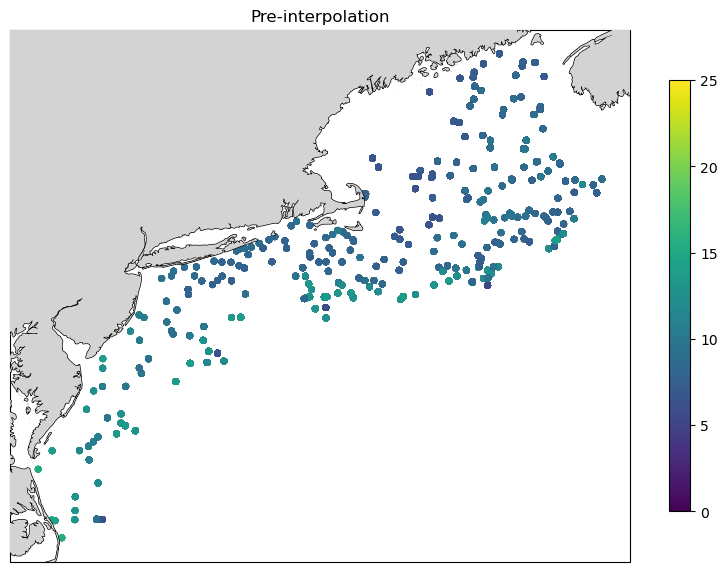

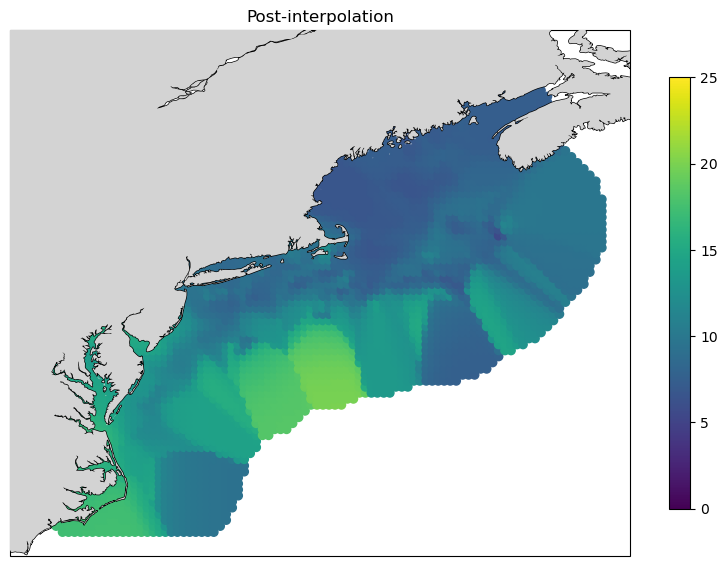

In [3]:
#get data
data = pd.read_csv('https://comet.nefsc.noaa.gov/erddap/tabledap/ocdbs_v_erddap1.csv?UTC_DATETIME%2Clatitude%2Clongitude%2Cdepth%2Cpressure_dbars%2Csea_water_temperature%2Csea_water_salinity%2Cdissolved_oxygen%2Cfluorescence%2Cpar_sensor%2Ccast_number%2Ccruise_id%2Cpurpose_code%2Cbottom_depth%2CGEAR_TYPE&UTC_DATETIME%3E=2016-05-01T00%3A00%3A00Z&UTC_DATETIME%3C=2016-05-31T00%3A00%3A00Z')
data = data[1:].reset_index()
data.latitude=data.latitude.astype(float)
data.longitude=data.longitude.astype(float)
data.sea_water_temperature=data.sea_water_temperature.astype(float)
data = data.rename(columns={'latitude':'lat','longitude':'lon'})
data= data.dropna(subset=['lat','lon', 'sea_water_temperature']) #important!!!

#visualize data (with holes)
fig = plt.figure(figsize=(10, 7)) #set figure size
map_projection = cartopy.crs.PlateCarree() #set map projection
ax = plt.axes(projection=map_projection) 
plt.scatter(data.lon,data.lat,c=data.sea_water_temperature,s=15, vmin=0,vmax=25)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=100, facecolor='lightgrey')
plt.title('Pre-interpolation')
plt.colorbar(shrink=0.8)

#set up for interpolation
V = data.sea_water_temperature
X = []
for a, b in zip(data.lat, data.lon ):
    X.append( [ a, b ] )
X = np.asarray(X)

#set up equidistant grid
xx = np.linspace(34.41,46.36,80)
yy = np.linspace(-77.68,-63.59,94)
Xv =(xx,yy) #GRID LOCATIONS
grid_size = (len(xx),len(yy))
gridX = np.meshgrid(xx,yy)[0].flatten()
gridY=np.meshgrid(xx,yy)[1].flatten()
gridX = np.round(gridX, decimals=2)
gridY= np.round(gridY, decimals=2)

Xq = []
for a, b in zip( gridX, gridY ):
    Xq.append( [ a, b ] )
Xq = np.asarray(Xq)

grid_size = [len(xx),len(yy)]

#interpolate
Vq, params = barnesn(X, V, Xv,data)

#visualize post interpolation
fig = plt.figure(figsize=(10, 7)) #set figure size
map_projection = cartopy.crs.PlateCarree() #set map projection
ax = plt.axes(projection=map_projection) 
plt.scatter(gridY,gridX,c=Vq.flatten(),vmin=0,vmax=25)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=100, facecolor='lightgrey')
plt.title('Post-interpolation')
plt.colorbar(shrink=0.8)


## <font color='darkblue'>Example 2</font> <a class="anchor" id="example2"></a>
Download OC-CCI chlorophyll for 1 day (in this case 7/2/24) and interpolate over missing grid cells. <br>
**NOTE:** Interpolating over gridded data is not the best use case for Barnes objective analysis, which is meant to interpolate unevenly spread data points onto a grid. This sample uses already gridded data for ease of demonstration. 

C:\Users\haley.synan\AppData\Local\Temp\ipykernel_19952\1946720783.py:54: UserWarning: Grid spacing should be larger than 0.021145955177913078. Smallest grid spacing: -0.041666666666671404. Data spacing: 0.06343786553373923
  warnings.warn('Grid spacing should be larger than ' + str(params['data_spacing']/3)+ '. Smallest grid spacing: '+ str(min_grid_spacing)+'. Data spacing: '
C:\Users\haley.synan\AppData\Local\Temp\ipykernel_19952\1946720783.py:57: UserWarning: Note that grid spacing can be smaller than 0.031718932766869615. Largest grid spacing: 0.041666666666671404. Data spacing: 0.06343786553373923
  warnings.warn('Note that grid spacing can be smaller than ' + str(params['data_spacing']/2) + '. Largest grid spacing: ' + str(max_grid_spacing) +


Barnes iteration 0, average RMS error is 0.025062718701087422
Barnes iteration 1, average RMS error is 0.012510288443609616
Barnes iteration 2, average RMS error is 0.0048583084411815925


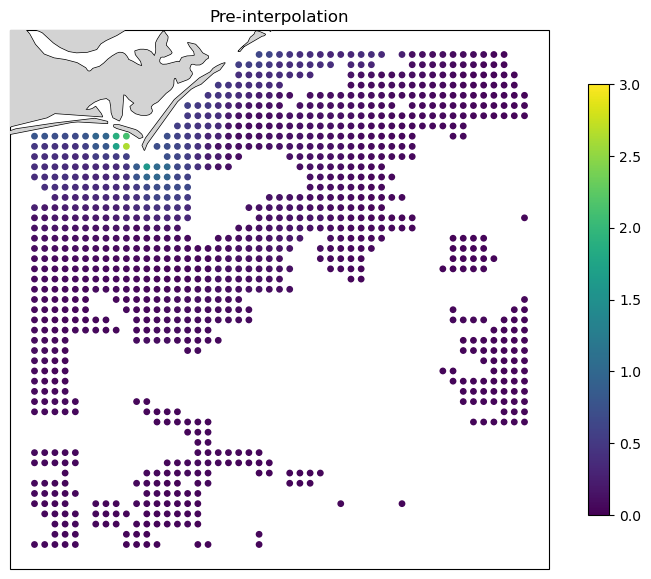

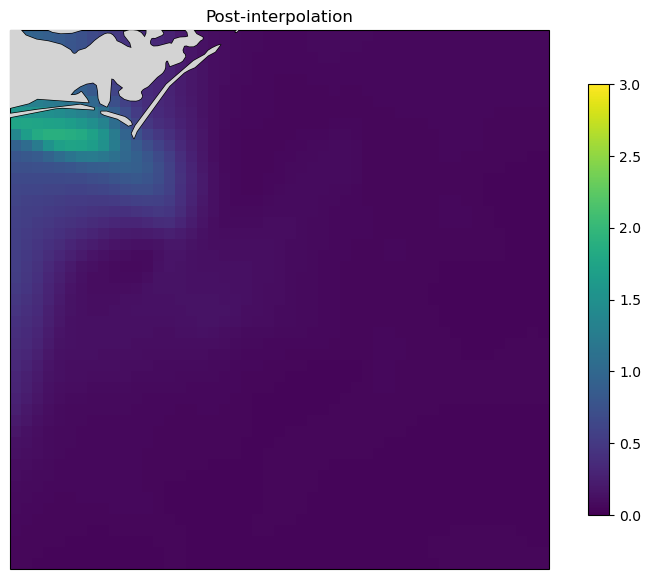

In [4]:
#SAMPLE IMPLEMENTATION

file = 'fname.nc'
try:
    ds=xr.open_dataset(file,decode_cf=True)
except:
    url=''.join(['https://www.oceancolour.org/thredds/ncss/CCI_ALL-v6.0-DAILY?var=chlor_a&north=44&west=-72&east=-67&south=40&horizStride=1&time_start=2024-07-02T00%3A00%3A00Z&time_end=2024-07-02T00%3A00%3A00Z&timeStride=1&accept=netcdf'])
    urllib.request.urlretrieve(url, file) #download data
    ds = xr.open_dataset(file, decode_cf=True) #open nc file 
input_data= ds.to_dataframe().dropna().reset_index()



#visualize data (with holes)
fig = plt.figure(figsize=(10, 7)) #set figure size
map_projection = cartopy.crs.PlateCarree() #set map projection
ax = plt.axes(projection=map_projection) 
plt.scatter(input_data.lon,input_data.lat,c=input_data.chlor_a,s=15, vmin=0, vmax=3)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=100, facecolor='lightgrey')
plt.title('Pre-interpolation')
plt.colorbar(shrink=0.8)


#set up for interpolation
V = input_data.chlor_a
X = []
for a, b in zip( input_data.lat, input_data.lon ):
    X.append( [ a, b ] )
X = np.asarray(X)

Xv =(ds.lat,ds.lon) #GRID LOCATIONS
gridX ,gridY= np.meshgrid(ds.lat,ds.lon)
gridX = np.round(gridX.flatten(), decimals=2)
gridY= np.round(gridY.flatten(), decimals=2)

Xq = []
for a, b in zip( gridX, gridY ):
    Xq.append( [ a, b ] )
Xq = np.asarray(Xq)

grid_size = [len(ds.lat),len(ds.lon)]

#interpolate
Vq, params = barnesn(X, V, Xv,input_data)

#visualize post interpolation
fig = plt.figure(figsize=(10, 7)) #set figure size
map_projection = cartopy.crs.PlateCarree() #set map projection
ax = plt.axes(projection=map_projection) 
plt.pcolormesh(ds.lon,ds.lat,Vq,vmin=0,vmax=3)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=100, facecolor='lightgrey')
plt.title('Post-interpolation')
plt.colorbar(shrink=0.8)